In [1]:
import numpy as np
import pandas as pd

def gen_uni_variance_data(length=1500, delta=10.0, lag=-3, tau=1.0, sigma=0.05):

    
    # let lag must be nagative integer
    if lag > 0:
        raise ValueError('Lag must be a negative integer.')


    time = np.arange(length, step=delta, dtype='float')
    A = np.zeros(len(time))
    B = np.zeros(len(time))

    A[0] = np.random.normal(0, sigma)
    B[0] = np.random.normal(0, sigma)

    alpha = np.exp(-delta / tau)
    
    for t in range(1, len(time)+lag):
        A[t] = alpha * A[t-1] + alpha * B[t+lag] + np.random.normal(0, sigma)
        B[t] = alpha * B[t-1] + alpha * A[t+lag] + np.random.normal(0, sigma)
    
    df = pd.DataFrame({
        'time': time,
        'A': A,
        'B': B
    })
    
    # drop nan values
    df = df.dropna()

    return df


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def gen_uni_variance_data(length=1500, delta=10.0, lag=-3, tau=1.0, sigma=0.05):
    # Ensure lag is negative
    if lag > 0:
        raise ValueError('Lag must be a negative integer.')

    # Create time array
    time = np.arange(length, step=delta, dtype='float')
    A = np.zeros(len(time))
    B = np.zeros(len(time))

    # Initialize the first element
    A[0] = np.random.normal(0, sigma)
    B[0] = np.random.normal(0, sigma)

    # Exponential decay factor
    alpha = np.exp(-delta / tau)
    
    for t in range(1, len(time)):
        if t+lag < 0 or t+lag >= len(time):  # To handle out-of-range indices
            continue
        A[t] = alpha * A[t-1] + alpha * B[t+lag] + np.random.normal(0, sigma)
        B[t] = alpha * B[t-1] + alpha * A[t+lag] + np.random.normal(0, sigma)
    
    # Convert to DataFrame
    df = pd.DataFrame({'time': time, 'A': A, 'B': B})
    
    # Drop rows with NaN values
    df.dropna(inplace=True)
    
    # Normalize A and B
    df['A'] = (df['A'] - df['A'].mean()) / df['A'].std()
    df['B'] = (df['B'] - df['B'].mean()) / df['B'].std()

    return df




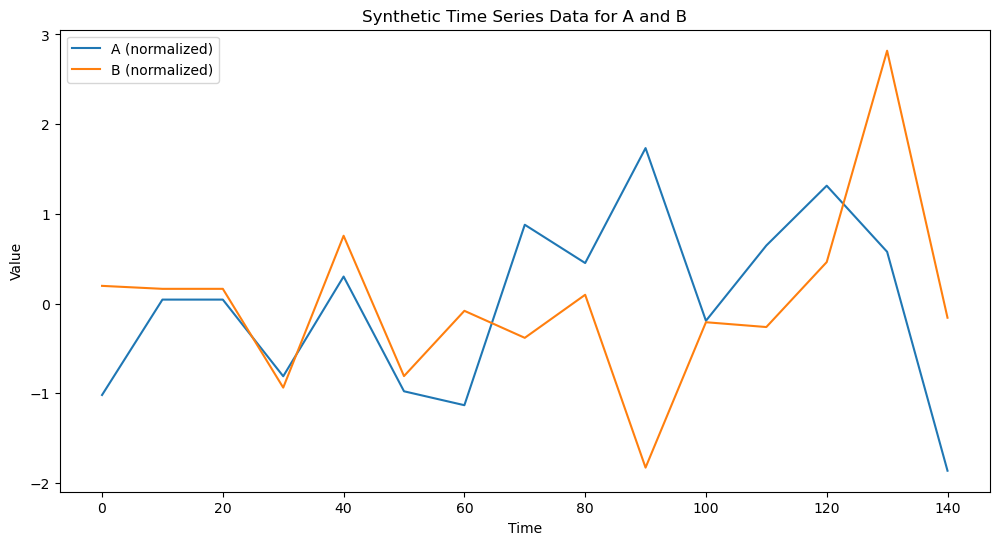

In [4]:
# Call the function
df = gen_uni_variance_data(length=150, delta=10.0, lag=-3, tau=1.0, sigma=0.05)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['A'], label='A (normalized)')
plt.plot(df['time'], df['B'], label='B (normalized)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data for A and B')
plt.legend()
plt.show()

# With Monte Carlo

In [6]:
import numpy as np
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module
from toolbox import syth_ana_functions as saf
import importlib
importlib.reload(saf)
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

ParCorr = parcorr.ParCorr(significance='analytic')

# Initialize parameters

len_data = np.arange(300, 1500, 150)  
lags = range(11)  # From 0 to 10
iterations = 10
causal_AB_results = np.zeros((len(len_data), len(lags)))
causal_BA_results = np.zeros((len(len_data), len(lags)))

causal_AB_true_count_all = np.zeros((len(len_data), len(lags)))
causal_BA_true_count_all = np.zeros((len(len_data), len(lags)))

# Loop through combinations of causal strengths and lags
for i, length in enumerate(len_data):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # data = saf.gen_bi_directional_data(length=1500, delta=10.0, lag=-lag, t0=800.0, dt=56.32925780771254, dy=1.0, GS_slope=0.00016431508734689263, GIS_slope=-0.0009404944834246113, tau=13.649751415738818, beta=strength, sigma=0.05)
            data=gen_uni_variance_data(length=length, delta=10.0, lag=-lag, tau=1.0, sigma=0.05)

            data = data[['A', 'B']]
            
            df_checked = GC.make_stationary(data,['A', 'B'], test_method='ADF', plot=False)
            AB_array = df_checked[['A', 'B']].values

            var_names=['A', 'B']
            # Create a Tigramite DataFrame object
            dataframe_sta = pp.DataFrame(AB_array,
                                    datatime=np.arange(len(AB_array)),
                                    var_names=var_names)


            tau_max=lag+1
            pcmci = PCMCI(
            dataframe=dataframe_sta,
            cond_ind_test=ParCorr,
            verbosity=1)

            pcmci.verbosity = 0
            results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)

            p_matrix = results['p_matrix']
            alpha_level = 0.05

            result = saf.get_link_direction(p_matrix, alpha_level)

            causal_AB = result[0]
            causal_BA = result[1]

            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95

        causal_AB_true_count_all[i, j] = causal_AB_true_count
        causal_BA_true_count_all[i, j] = causal_BA_true_count


causal_results_red_nozscore = np.where((causal_AB_results == 1) & (causal_BA_results == 1), 1, 0)

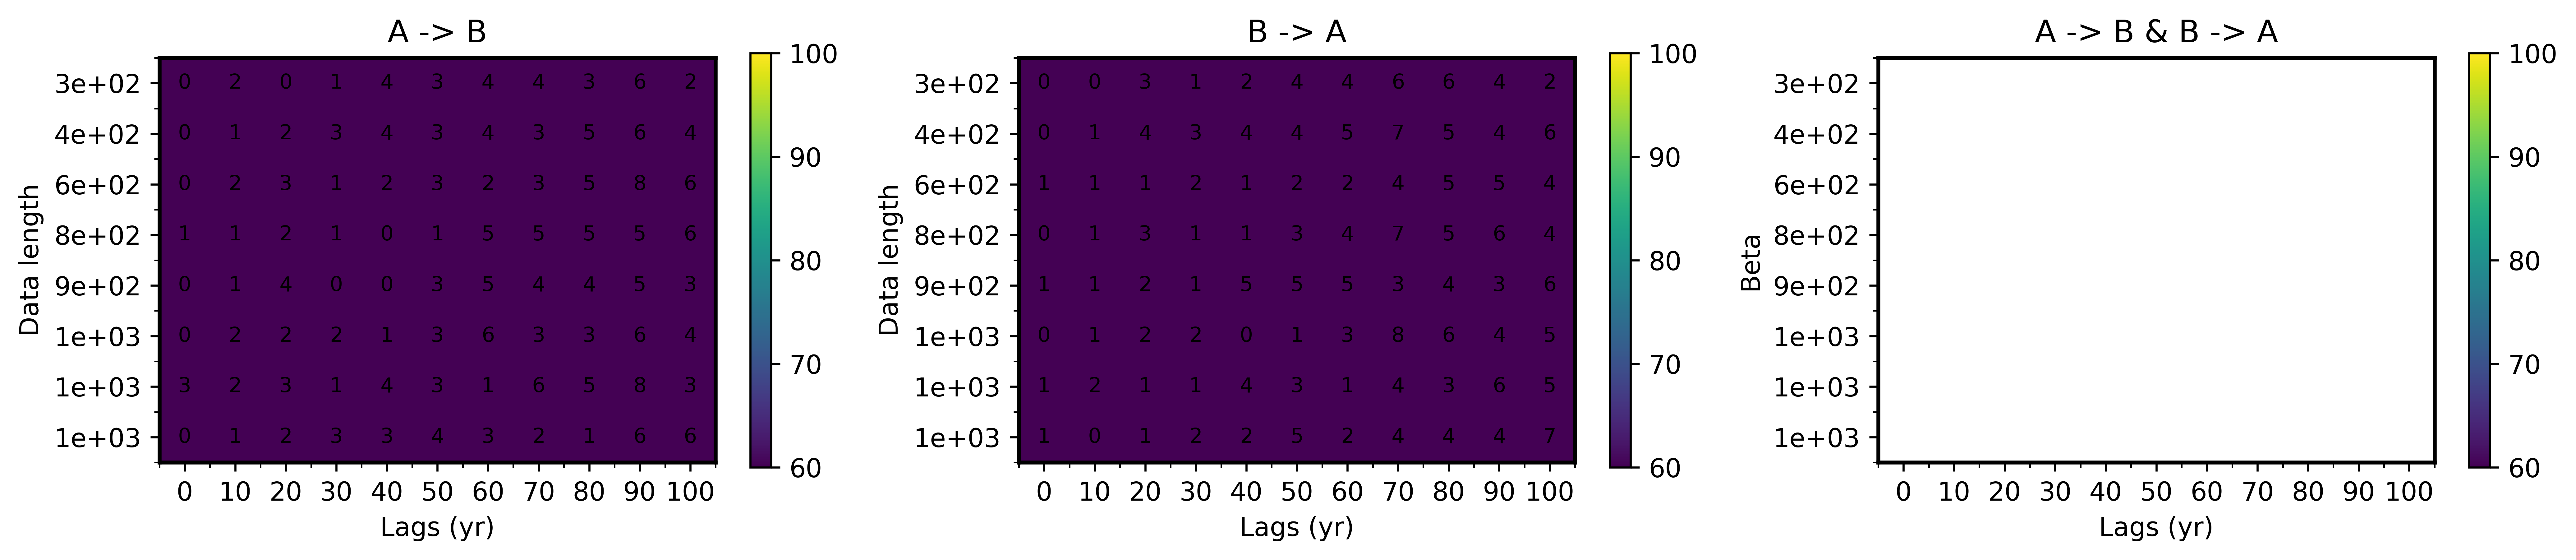

In [8]:
from toolbox import syth_ana_functions as saf
import matplotlib.pyplot as plt
import importlib    
importlib.reload(saf)

len_data = np.arange(300, 1500, 150) 
lags = range(11)  # From 0 to 10

X=np.array(lags)
Y=np.array(len_data)



fig, axs = plt.subplots(1, 3, figsize=(14,4), dpi=600)  # 1 row, 3 columns of plots

# Plot each of the causal matrices with text annotations
saf.causal_colormap_ax(causal_AB_results, causal_AB_true_count_all, axs[0], X=X, Y=Y, title='A -> B', ylabel='Data length',show_counts=True,vmin=60, vmax=100)
saf.causal_colormap_ax(causal_BA_results, causal_BA_true_count_all, axs[1], X=X, Y=Y, title='B -> A', ylabel='Data length',show_counts=True, vmin=60, vmax=100)

# create AB_BA_count, and if causal_results_red_nozscore is 1, set the value in AB_BA count to the value from the causal_AB_true_count_all
AB_BA_count = np.zeros((len(len_data), len(lags)))
for i in range(len(len_data)):
    for j in range(len(lags)):
        if causal_results_red_nozscore[i,j] == 1:
            AB_BA_count[i,j] = causal_AB_true_count_all[i,j]
        else:
            AB_BA_count[i,j] = np.nan


# Assuming causal_results_red_nozscore is derived in your existing code
saf.causal_colormap_ax(causal_results=causal_results_red_nozscore, counts=AB_BA_count, ax=axs[2], X=X, Y=Y, title='A -> B & B -> A', ylabel='Beta',show_counts=True, vmin=60, vmax=100)
plt.tight_layout()
plt.show()